# Ścieżka wirów Kármána

Opływ rzeczywistej cieczy przez nieskończony cylinder (lub koło w 2d) dla małych liczb Re jest laminarny i pole prędkości przypomina przepływ potencjalny. Jednak zwiększając liczbę Re pojawia się para wirów za przeszkodą, które wraz ze zwiększająca się Re tracą stabilność na rzecz stanu oscylacyjnego. 

- https://www.youtube.com/watch?v=PJW341Zc9TE
- https://www.youtube.com/watch?v=JI0M1gVNhbw
- https://www.youtube.com/watch?v=_AJgEa2dbJU

Zbadajmy jak zachowuje sie taki układ.


###Wykonaj:

1. Uruchom poniższą symulacje dla parametrów: 

 - $nu_{LB}=0.01$: parametr `-visc=0.01`
 - rozmiaru siatki układu $nx=126$ oraz $ny=510$ 

 W tym przypadku napędzimy układ siłą objętościowa (gęstością siły), którą w kodzie zadajemy przez np.:

    self.add_body_force((15e-7, 0.0))

 Poniższa symulacja zawiera w połowie wysokości dysk o średnicy 20[lu]. 

2. Zbadaj zachowanie się układu dla kilku wartości siły objętościowej działająca na ciecz. Zwiększająć siłę zwiększamy   prędkość przepływu a tym samym Re.

  W każdym przypadku oblicz liczbę Reynoldsa dla w/w układu, jako rozmiar charakterystyczny przyjmij rozmiar   przeszkody w jednostkach sieci. Prędkość charakterystyczna niech bedzie maksymalną prędkością w układzie. 


  - $0.5\times 10^{-7}$: $v_{max}=?$, $Re=?$, zawirowanie za przeszkodą?, złamanie symetrii w $y$?, ustala się przepływ stały|okresowy|nieokresowy
  - $5 \times 10^{-7}$: $v_{max}=?$, $Re=?$, zawirowanie za przeszkodą?, złamanie symetrii w $y$?, ustala się przepływ stały|okresowy|nieokresowy
  - $15 \times 10^{-7}$: $v_{max}=?$, $Re=?$, zawirowanie za przeszkodą?, złamanie symetrii w $y$?, ustala się przepływ stały|okresowy|nieokresowy
  - $20 \times 10^{-7}$: $v_{max}=?$, $Re=?$, zawirowanie za przeszkodą?, złamanie symetrii w $y$?, ustala się przepływ stały|okresowy|nieokresowy









In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('./sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


/dev/shm/marcin.kostur/data :: File exists


In [2]:
%%writefile data/karman.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim, LBForcedSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
       
        diam = 20
        x0 = 2 * diam
        y0 = self.gy / 2
        
        self.set_node(hy == 0, NTFullBBWall)
        self.set_node(hy == self.gy - 1, NTFullBBWall)
        cylinder_map = np.square(hx - x0) + np.square(hy - y0) < diam**2 / 4.0
        
        not_wall = (hy > 0) & (hy < self.gy - 1)
        
        self.set_node(cylinder_map, NTFullBBWall)
     
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0

class MySim(LBFluidSim, LBForcedSim):
    
    subdomain = MyBlock

    def __init__(self, config):
        super(MySim, self).__init__(config)
        self.add_body_force((15e-7, 0.0))

LBSimulationController(MySim).run()

Writing data/karman.py


In [3]:
%%sh
rm data/karman*npz
export PYTHONPATH=$PWD/sailfish/
python data/karman.py --max_iters=100000 --from=0000 --every=10000 \
 --lat_nx=510 --lat_ny=126 --model=mrt \
 --visc=0.01 --periodic_x\
 --output=data/karman --output_format=npy

rm: cannot remove ‘data/karman*npz’: No such file or directory
[   753  INFO Master/GPU2] Machine master starting with PID 55607 at 2016-06-07 22:01:49 UTC
[   753  INFO Master/GPU2] Simulation started with: data/karman.py --max_iters=100000 --from=0000 --every=10000 --lat_nx=510 --lat_ny=126 --model=mrt --visc=0.01 --periodic_x --output=data/karman --output_format=npy
[   767  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   767  INFO Master/GPU2] Handling subdomains: [0]
[   767  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   767  INFO Master/GPU2] Selected backend: cuda
[  1002  INFO Subdomain/0] Initializing subdomain.
[  1003  INFO Subdomain/0] Required memory: 
[  1003  INFO Subdomain/0] . distributions: 4 MiB
[  1003  INFO Subdomain/0] . fields: 0 MiB
[  4280  INFO Subdomain/0] Starting simulation.
[  4483  INFO Subdomain/0] iteration:2000  speed:733.65 MLUPS
[  4563  INFO Subdomain/0] iteration:3000  speed:777.77 MLUPS
[  4643  INFO Subdomain

In [ ]:
!ls data/karman* -rtla|tail


Max v: 0.0917029
Re: 17.4235596508 dt: 0.000196463654224 dx: 0.00196463654224


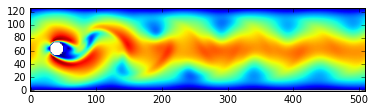

In [4]:
data = np.load("data/karman.0.100000.npz")
data.files
data['v'][0].shape
vx,vy = data['v'] 
ny,nx = vx.shape
print "Max v:",np.nanmax(vx)
visc = 0.1
u_lb = np.nanmax(vx)
Re = u_lb*(20-1)/visc
dx = (1.0/(nx-1))
dt = 0.1/1.0*dx
print "Re:",Re,"dt:",dt,"dx:",dx
plt.imshow(np.sqrt(vx**2+vy**2),origin='top')

## Analiza czasowej ewolucji przepływu

Możemy łatwo przeanalizować przebieg symulacji z zapisanych pol makroskopowych na dysku. Poniższy kod:
 
 - wczytuje wszystkie pliki pasujące do wzorca `data/karman.*.npz`
 - korzystając z elementów interaktywnych w IPython, rysuje pole skalarne wybranej wielkości lub chwilewe linie  prądu w zadanym kroku czasowym
 
`plt.imshow` jest najszybszą metodą wizualizacji pola skalarnego. `plt.streamlines` jest dużo wolniejsze, dlatego dla zapewnienia płynniejszego działania warto mieć kontrolę nad tym co jest rysowane. W przypadku większych pół należy użyć odpowieniego filtrowania za pomocą techniki `slice` by rysowanie jednek klatki nie trwało długo.

In [5]:
%%time 
import glob
frames = []
s = (slice(None),slice(None))
#s = (slice(80,170,1),slice(20,220,1))
#s = (slice(None),slice(None,200,1))

for fn in sorted(glob.glob("data/karman.*.npz")):
    data =np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])


CPU times: user 108 ms, sys: 12 ms, total: 120 ms
Wall time: 119 ms


In [23]:

w = widgets.Dropdown(options=[('Addition',33),( 'Multiplication',321)])
w

In [24]:
w.value

33

0.0884918


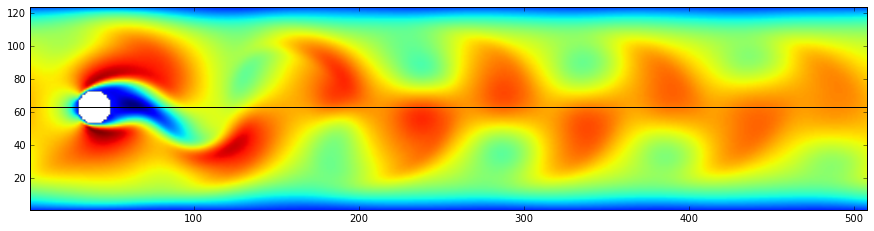

In [28]:
from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options=[('vx',0),('vy' , 1), ('rot v', 2),('rho',3)],value=0),\
         stream=widgets.Checkbox())
def g(ith,figsize,sel,stream):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')#,vmin=-0.1,vmax=0.1)
    if stream:
        plt.streamplot(X,Y,vx,vy,color='white',density=1)
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    print np.nanmax(vx)
    plt.show()